# Lab Six

## Main Assignment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
import math

### Correct File

In [2]:
with open('data/titanic.csv') as input_file:
    with open('data/data_titanic.csv', 'w') as output_file:
        lines = []
        statuses = []
        for index, line in enumerate(input_file):
            if index == 0:
                lines.append(line.replace(',', ';'))
                continue
            parts = line.split('"')
            parts[0] = parts[0].replace(',', ';')
            parts[2] = parts[2].replace(',', ';')
            statuses.append(parts[1].split(',')[1].split('.')[0].lstrip())
            lines.append(''.join(parts))
        statuses = list(set(statuses))
        output_file.writelines(lines)

### Status-Gender Pairs

In [3]:
status_gender_pairs = {
    'Rev': 'male',
    'Miss': 'female',
    'Ms': 'male',
    'Dr': 'male',
    'Mlle': 'female',
    'Col': 'male',
    'the Countess': 'female',
    'Jonkheer': 'male',
    'Don': 'male',
    'Capt': 'male',
    'Master': 'male',
    'Mme': 'female',
    'Mrs': 'female',
    'Mr': 'male',
    'Lady': 'female',
    'Sir': 'male',
    'Major': 'male'
}

### Load Dataframe

In [4]:
df = pd.read_csv('data/data_titanic.csv', delimiter=';', decimal='.')

### Drop unnecessary columns

In [5]:
df = df.drop(['PassengerId'], axis=1)

### Take a look on what data is missing

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


<AxesSubplot: >

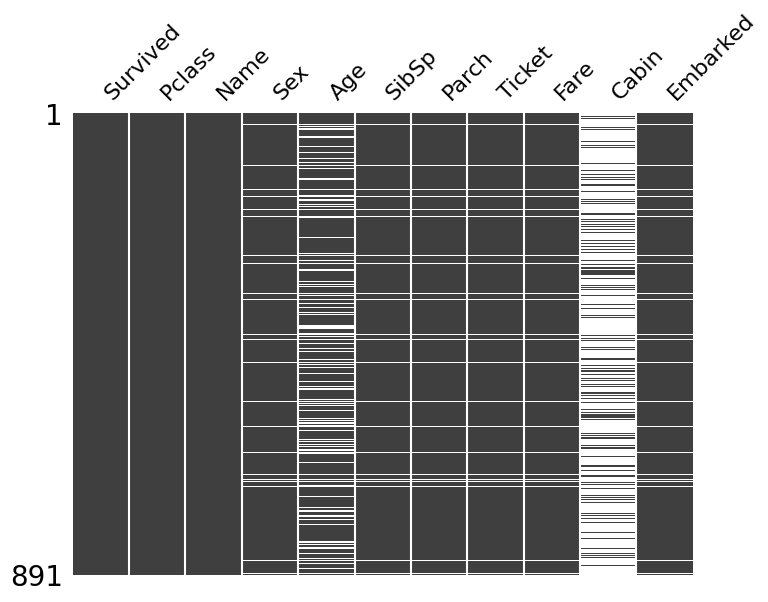

In [6]:
percent_1 = df.isnull().sum() / df.isnull().count() * 100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([percent_2], axis=1, keys=['%'])
plot_rows = 1
plot_cols = 1
fig, axis = plt.subplots(plot_rows, plot_cols, figsize=(8, 6))
msno.matrix(df, ax=axis)

### Empty values by percentage in column

<BarContainer object of 11 artists>

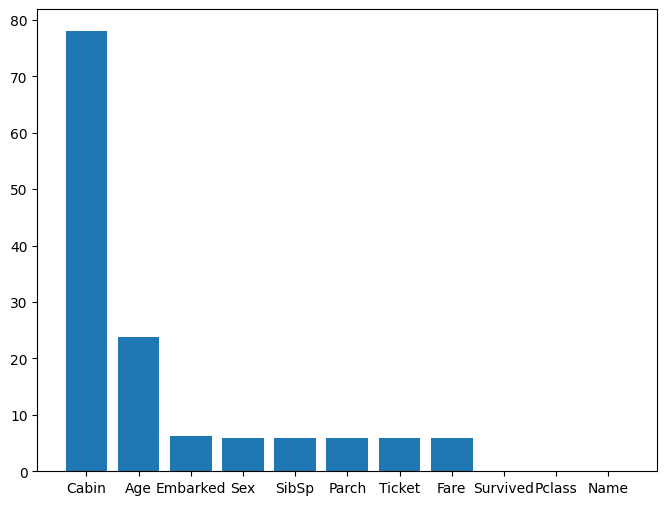

In [7]:
fig, axis = plt.subplots(plot_rows, plot_cols, figsize=(8, 6))
axis.bar(missing_data.index, missing_data.iloc[:, 0])

### Drop "Cabin" due to large number of missing data

In [8]:
df = df.drop(['Cabin'], axis=1)

### Fill Nan "Age"-values with mean

In [9]:
df_sex_mean_age = pd.pivot_table(df, index='Sex', values='Age', aggfunc='mean')
mean_age_female, mean_age_male = df_sex_mean_age.iloc[0, 0], df_sex_mean_age.iloc[1, 0]
df_sex_mean_age

,Age
Sex,
female,28.445833
male,30.863713


### Fill gender

In [10]:
df['Sex'] = df.apply(lambda x: status_gender_pairs[x['Name'].split(',')[1].split('.')[0].lstrip()], axis=1)
df['Gender'] = df.apply(lambda x: x['Sex'] == 'male', axis=1)

def mean_age_functor(row):
    if str(row['Age']) != 'nan':
        return row['Age']
    if row['Sex'] == 'male':
        return mean_age_male
    return mean_age_female


df['Age'] = df.apply(mean_age_functor, axis=1)

### Fill "Embarked" with the most frequent value

([<matplotlib.patches.Wedge at 0x7fb0f09fb1f0>,
 [Text(-0.7389062157855284, 0.8148727534244291, 'S'),
  Text(0.5271737867829742, -0.9654469423686107, 'C'),
  Text(1.069316711618934, -0.2579956787476679, 'Q')],
 [Text(-0.4030397540648336, 0.4444760473224158, '73.4%'),
  Text(0.28754933824525863, -0.5266074231101512, '19.0%'),
  Text(0.5832636608830548, -0.1407249156805461, '7.5%')])

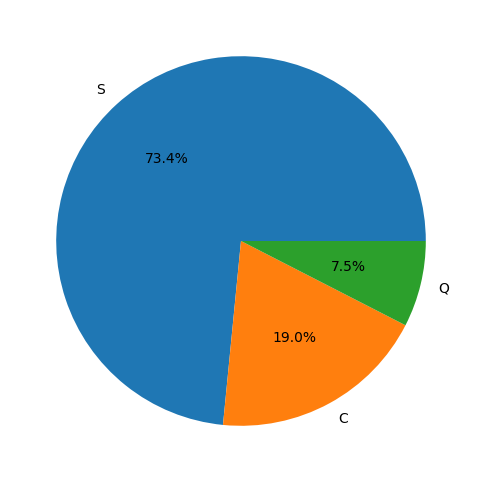

In [11]:
fig, axis = plt.subplots(figsize=(8, 6))
embarked_counts = df['Embarked'].value_counts()
axis.pie(embarked_counts, labels=embarked_counts.index, autopct='%1.1f%%')

### Fill empty embarked with "S"

In [12]:
df['Embarked'].fillna('S', inplace=True)
df['EmbarkedValue'] = df.apply(lambda x: ['S', 'Q', 'C'].index(x['Embarked']), axis=1)

### Fill "Fare" with mean

In [13]:
df['Fare'].fillna(value=df['Fare'].mean(), inplace=True)
df['SibSp'].fillna(value=0, inplace=True)
df['Parch'].fillna(value=0, inplace=True)
df['Relatives'] = df['SibSp'] + df['Parch']
df = df.drop(['Parch', 'SibSp'], axis=1)

### Since the Ticket attribute has 681 unique tickets, it is fair to drop that column

In [14]:
df['Ticket'].describe()

count      838
unique     647
top       1601
freq         7
Name: Ticket, dtype: object

In [15]:
df = df.drop(['Ticket'], axis=1)

### Change column types

In [16]:
for row in df.columns:
    if df[row].dtype == bool:
        df[row] = df[row].astype(int)

### Plot correlation matrix

<AxesSubplot: >

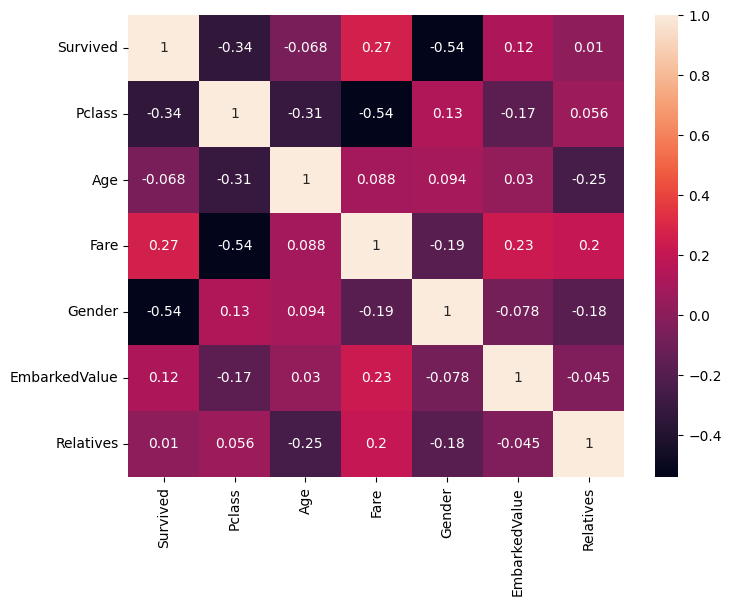

In [17]:
fig, axis = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), ax=axis, annot=True)

### Plot all correlations

/tmp/ipykernel_24091/1656986452.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(df, ax=axis)


array([[<AxesSubplot: xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot: xlabel='Age', ylabel='Survived'>,
        <AxesSubplot: xlabel='Fare', ylabel='Survived'>,
        <AxesSubplot: xlabel='Gender', ylabel='Survived'>,
        <AxesSubplot: xlabel='EmbarkedValue', ylabel='Survived'>,
        <AxesSubplot: xlabel='Relatives', ylabel='Survived'>],
       [<AxesSubplot: xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Fare', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Gender', ylabel='Pclass'>,
        <AxesSubplot: xlabel='EmbarkedValue', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Relatives', ylabel='Pclass'>],
       [<AxesSubplot: xlabel='Survived', ylabel='Age'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Age'>,
        <AxesSubplot: xlabel='Age', ylabel='Age'>,
        <Ax

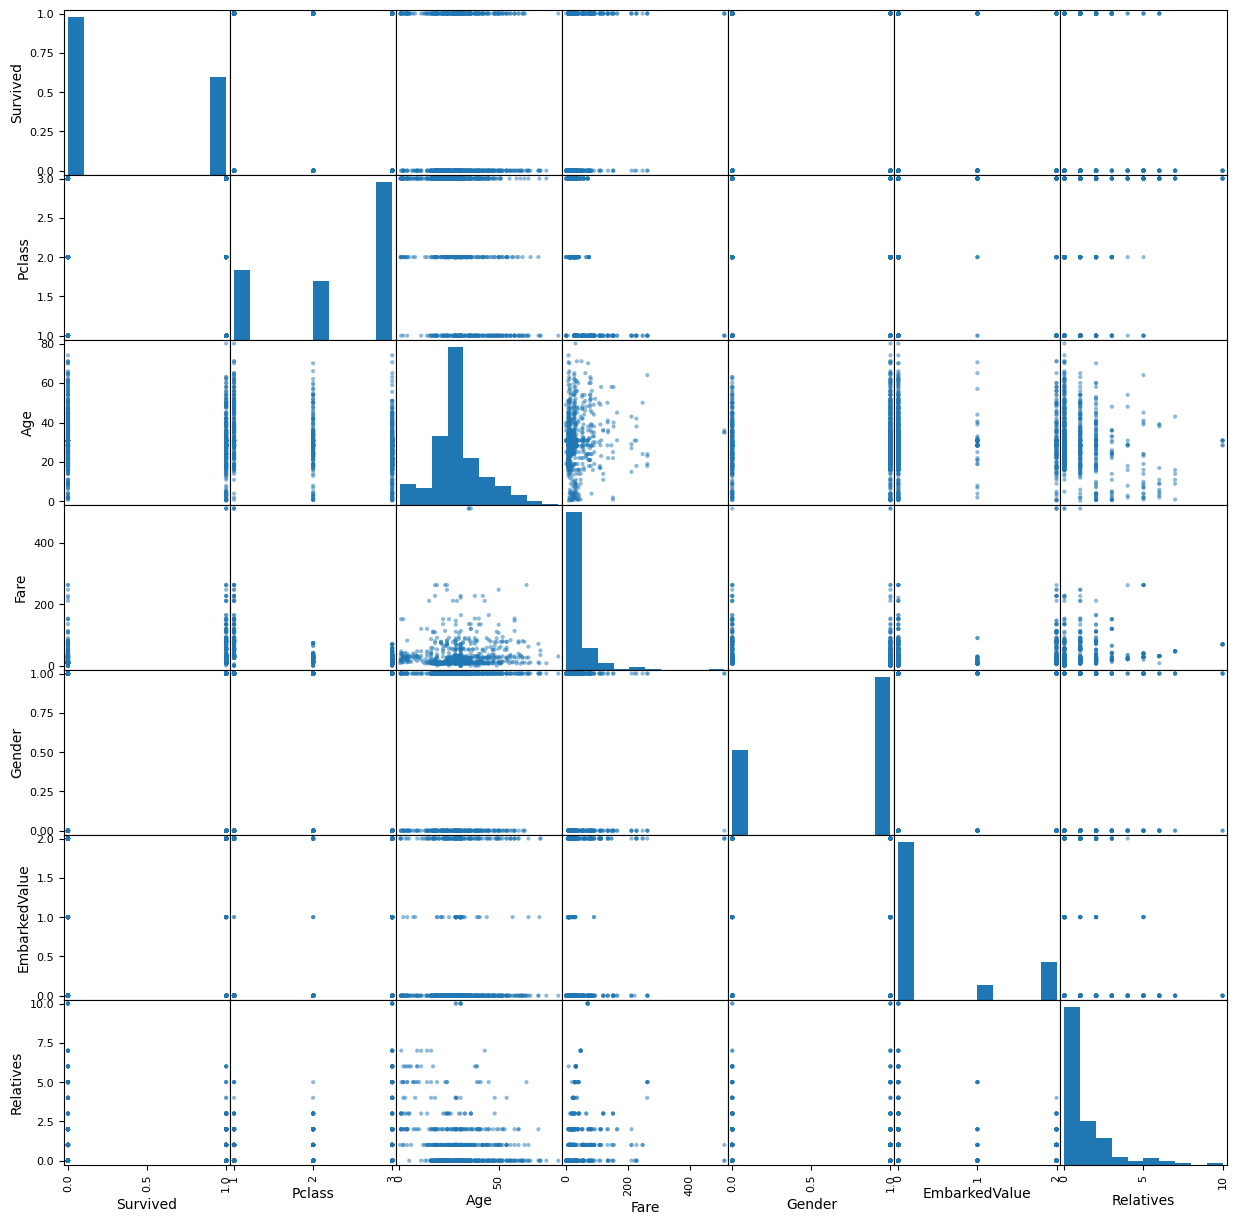

In [18]:
fig, axis = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(df, ax=axis)

### Plot male-female Age statistic

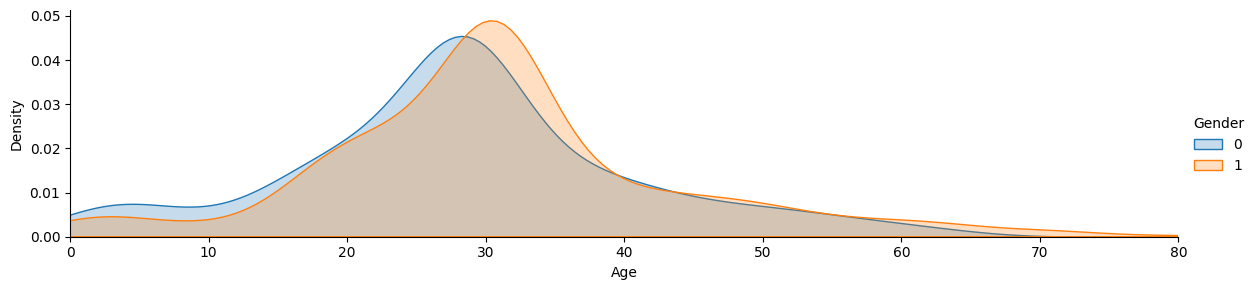

In [19]:
fig = sns.FacetGrid(df, hue='Gender', aspect=4)
fig.map(sns.kdeplot, 'Age', fill=True)
oldest = df['Age'].max()
fig.set(xlim=(0, oldest))
fig.add_legend()

### Plot male-female Count statistic

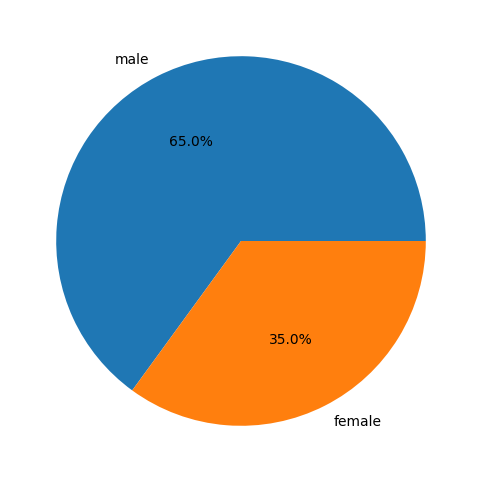

In [20]:
fig, axis = plt.subplots(figsize=(8, 6))
male_female_counts = df['Sex'].value_counts()
axis.pie(male_female_counts, labels=male_female_counts.index, autopct='%1.1f%%')


factors = df.columns.values.tolist()
factors = [f for f in factors if f not in ['Sex', 'Survived', 'Gender', 'Name', 'EmbarkedValue']]

### Plot male-female Survival Rate based on Age statistic

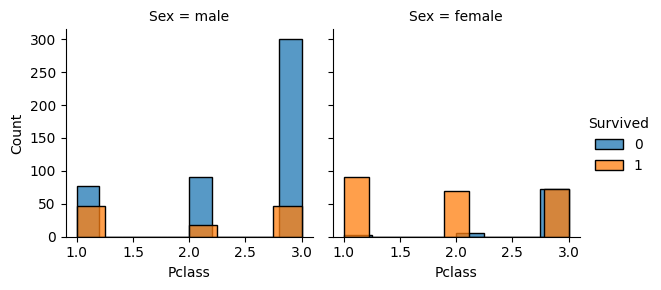

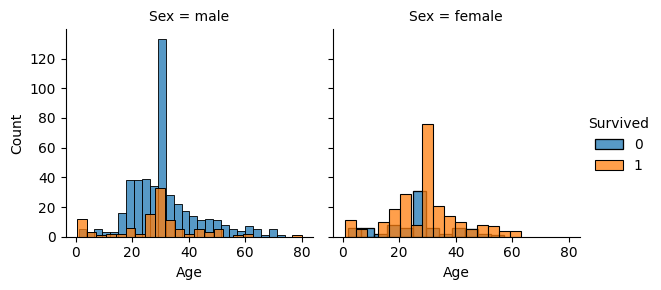

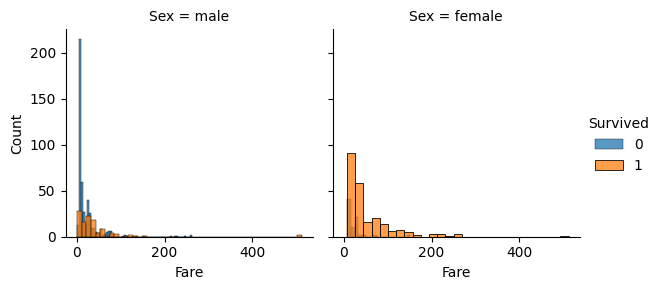

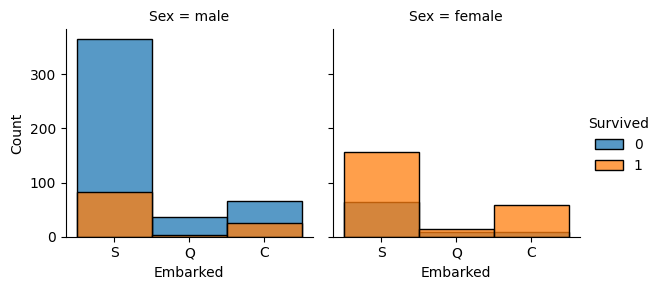

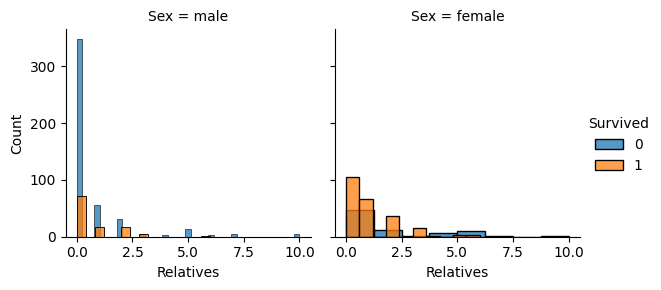

In [21]:
for row, factor in enumerate(factors):
    g = sns.FacetGrid(df[['Sex', 'Survived'] + [factor]], col='Sex', hue='Survived')
    g.map(sns.histplot, factor)
    g.add_legend()

### KMeans without PCA

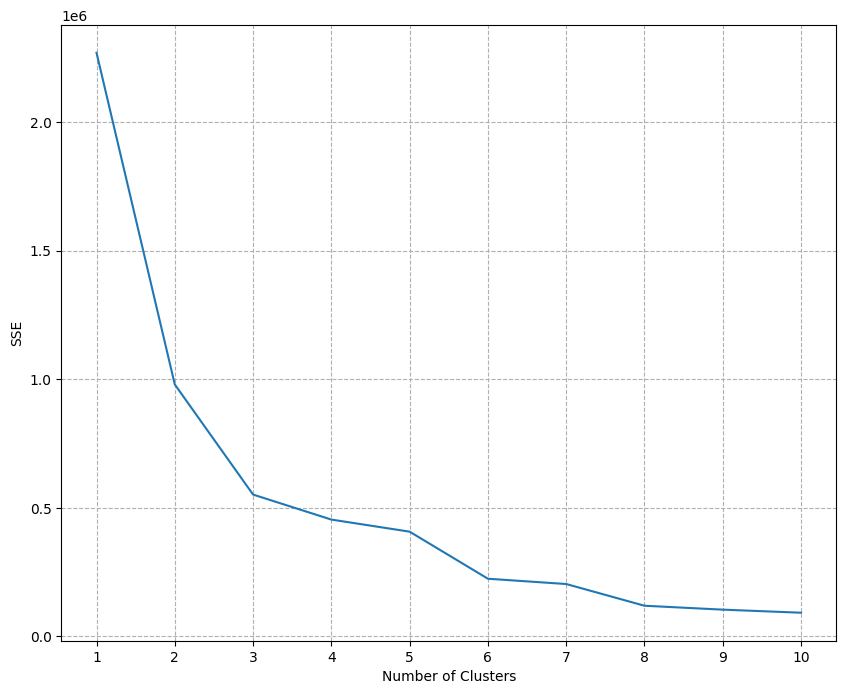

In [22]:
factors.remove('Embarked')
factors.append('EmbarkedValue')
kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 0,
}
sse = []
max_kernels = 10
features = df[['Survived'] + factors]
for k in range(1, max_kernels + 1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, max_kernels + 1), sse)
plt.xticks(range(1, max_kernels + 1))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(linestyle='--')

### Elbow point

In [23]:
kl = KneeLocator(range(1, max_kernels + 1), sse, curve='convex', direction='decreasing')
kl.elbow

3

### Set number of clusters to elbow point

In [24]:
kmeans = KMeans(
    init='random',
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=0
)
kmeans.fit(features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=0)

In [25]:
kmeans.cluster_centers_

array([[  0.67391304,   1.23913043,  34.96908602,  83.96026449,
          1.41304348,   0.72463768],
       [  0.32152589,   2.54359673,  29.03663864,  16.70048021,
          0.72752044,   0.35286104],
       [  0.68421053,   1.        ,  31.66986452, 280.19978421,
          1.68421053,   1.15789474]])

In [26]:
fig = px.scatter_3d(
    df, x='Survived', y='Fare', z='Relatives',
    color=kmeans.labels_, hover_data=['Sex', 'Age', 'EmbarkedValue'],
    width=1000, height=800,
    title='Survived-Fare-Relatives KMeans Plot Clusters'
)
fig.update(layout_coloraxis_showscale=False)
fig.show()

### Agglomerate Clustering

In [27]:
model = AgglomerativeClustering(n_clusters=kl.elbow, affinity='euclidean', linkage='ward')
clust_labels = model.fit_predict(features)
agglomerative = pd.DataFrame(clust_labels)
agglomerative

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



,0
0,1
1,2
2,1
3,1
4,1
...,...
886,1
887,1
888,1
889,1


In [28]:
df.insert((df.shape[1]), 'agglomerative', agglomerative)
fig = px.scatter_3d(
    df, x='Survived', y='Fare', z='Relatives',
    color=df['agglomerative'], hover_data=['Sex', 'Age', 'EmbarkedValue'],
    width=1000, height=800,
    title='Survived-Fare-Relatives Agglomerative Plot Clusters'
)
fig.update(layout_coloraxis_showscale=False)
fig.show()

## Results

### Результати кластеризації показують невелику різницю у двох методах на даному наборі даних. Можливо, що інформації замало, тому не показується різниця

# Additional Assignment

## Useful Funcs

In [29]:
def read_dataset(path: str, sep: str = ';') -> pd.DataFrame:
    data = pd.read_csv(path, sep=sep)
    return data


def replace_comma_with_dots(dataset: pd.DataFrame, column_name: str) -> None:
    dataset[column_name] = dataset[column_name].astype(str)
    dataset[column_name] = dataset[column_name].str.replace(',', '.')


def convert_column_to_float(dataset: pd.DataFrame, column_name: str) -> None:
    dataset[column_name] = dataset[column_name].astype(float)


def replace_nan_with_mean(dataset: pd.DataFrame, column_name: str):
    mean_value = dataset[column_name].mean()
    dataset[column_name].fillna(value=mean_value, inplace=True)


def convert_float_with_positive(dataset: pd.DataFrame, column_name: str):
    dataset[column_name] = dataset[column_name].abs()

## Read Dataset and filter it

In [30]:
data_path = 'data/Data2.csv'
df = read_dataset(data_path, sep=';')

df['Population'] = df['Populatiion']
df = df.drop(['Populatiion'], axis=1)

numeric_cols = df.columns[2:]

for column_name in numeric_cols:
    replace_comma_with_dots(df, column_name)
    convert_column_to_float(df, column_name)
    replace_nan_with_mean(df, column_name)
    convert_float_with_positive(df, column_name)
    print(column_name, df[column_name].dtype)

## density column
df['GDP'] = df['GDP per capita'] * df['Population']

df['Density'] = df['Population'] / df['Area']
df.head(10)

GDP per capita float64
CO2 emission float64
Area float64
Population float64


,Country Name,Region,GDP per capita,CO2 emission,Area,Population,GDP,Density
0,Afghanistan,South Asia,561.778746,9809.225000,652860.0,34656032.0,1.946902e+10,53.083405
1,Albania,Europe & Central Asia,4124.982390,5716.853000,28750.0,2876101.0,1.186387e+10,100.038296
2,Algeria,Middle East & North Africa,3916.881571,145400.217000,2381740.0,40606052.0,1.590491e+11,17.048902
3,American Samoa,East Asia & Pacific,11834.745230,165114.116337,200.0,55599.0,6.580000e+08,277.995000
4,Andorra,Europe & Central Asia,36988.622030,462.042000,470.0,77281.0,2.858518e+09,164.427660
5,Angola,Sub-Saharan Africa,3308.700233,34763.160000,1246700.0,28813463.0,9.533511e+10,23.111786
6,Antigua and Barbuda,Latin America & Caribbean,14462.176280,531.715000,440.0,100963.0,1.460145e+09,229.461364
7,Argentina,Latin America & Caribbean,12440.320980,204024.546000,2780400.0,43847430.0,5.454761e+11,15.770188
8,Armenia,Europe & Central Asia,3614.688357,5529.836000,29740.0,2924816.0,1.057230e+10,98.346200
9,Aruba,Latin America & Caribbean,13374.833168,872.746000,180.0,104822.0,1.401977e+09,582.344444


## Factors

In [31]:
factors = df.columns.values.tolist()
factors = [f for f in factors if f not in ['Region', 'Country Name']]

## Frequency diagrams

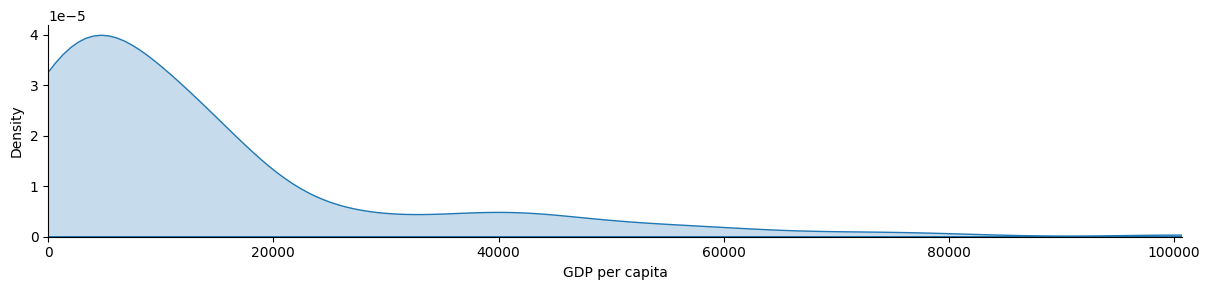

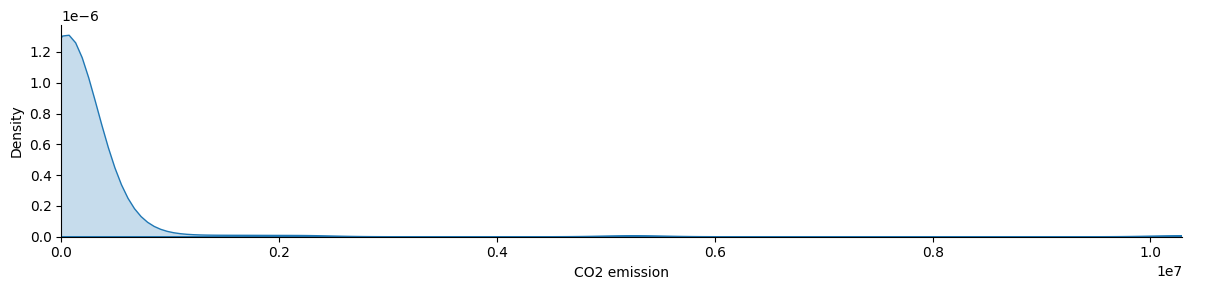

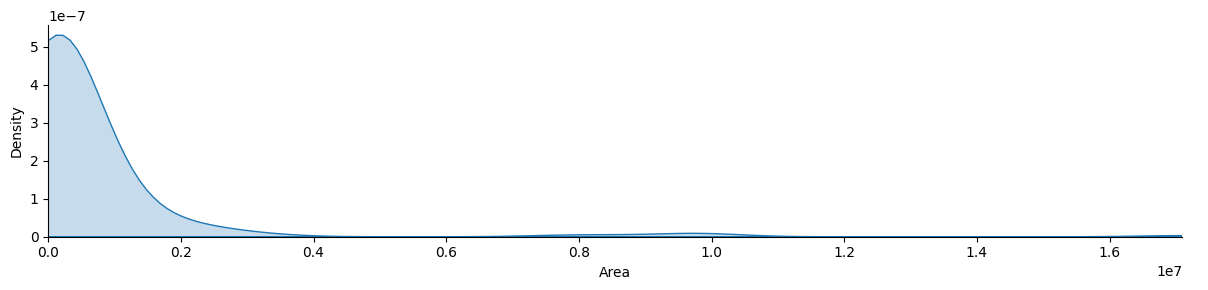

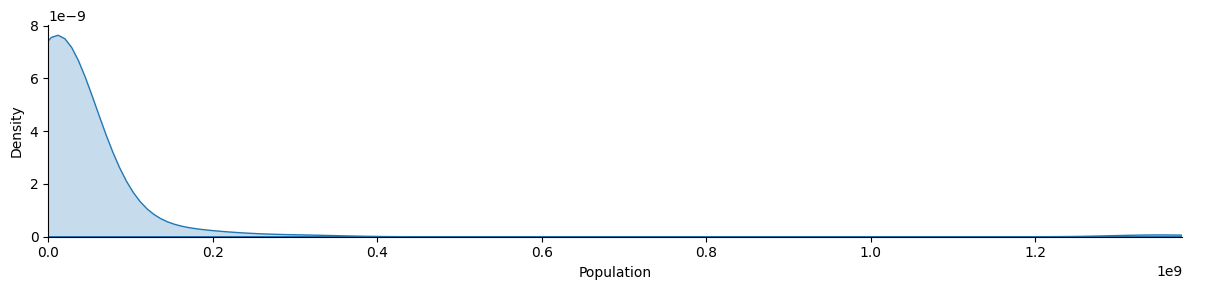

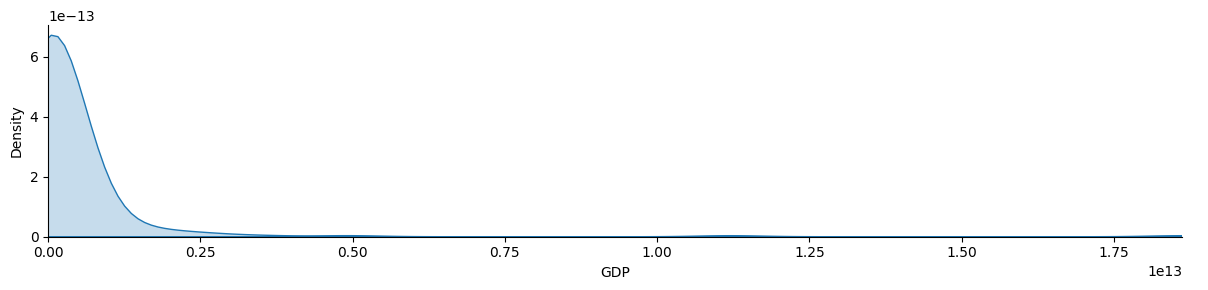

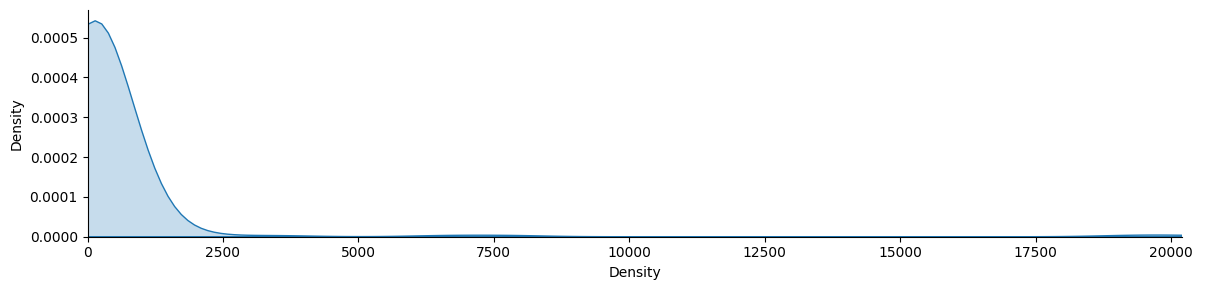

In [32]:
for column_name in factors:
    fig = sns.FacetGrid(df, aspect=4)
    fig.map(sns.kdeplot, column_name, fill=True)
    oldest = df[column_name].max()
    fig.set(xlim=(0, oldest))
    fig.add_legend()

## Check for linear correlation

<AxesSubplot: >

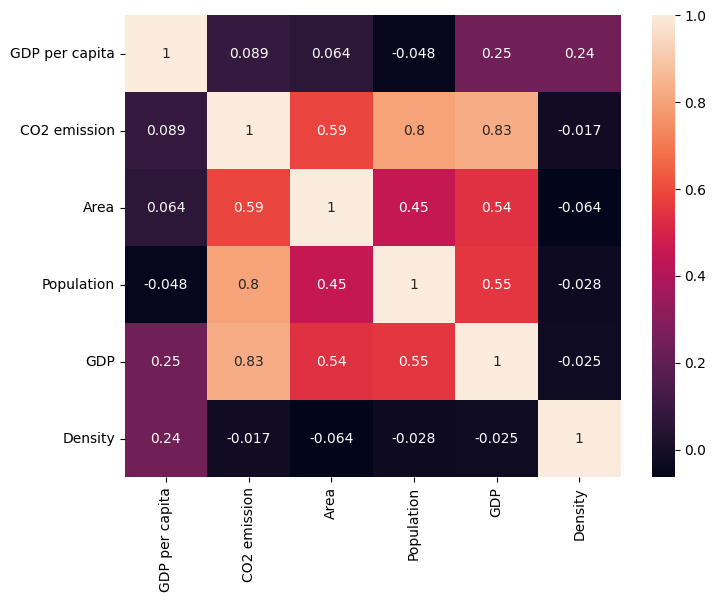

In [33]:
df_nums = df[factors]
fig, axis = plt.subplots(figsize=(8, 6))
sns.heatmap(df_nums.corr(numeric_only=True), ax=axis, annot=True)

## Linear Func

In [34]:
def is_linear(series_one: pd.Series, series_two: pd.Series) -> bool:
    return math.fabs(series_one.corr(series_two)) >= 0.8

rows = []
for c_one in factors:
    corrs_row = [{c: is_linear(df[c_one], df[c])} for c in factors]
    pairs = {}
    for cc in corrs_row:
        pairs.update(cc)
    row = {c_one: pairs}
    rows.append(row)
rows

[{'GDP per capita': {'GDP per capita': True,
   'CO2 emission': False,
   'Area': False,
   'Population': False,
   'GDP': False,
   'Density': False}},
 {'CO2 emission': {'GDP per capita': False,
   'CO2 emission': True,
   'Area': False,
   'Population': True,
   'GDP': True,
   'Density': False}},
 {'Area': {'GDP per capita': False,
   'CO2 emission': False,
   'Area': True,
   'Population': False,
   'GDP': False,
   'Density': False}},
 {'Population': {'GDP per capita': False,
   'CO2 emission': True,
   'Area': False,
   'Population': True,
   'GDP': False,
   'Density': False}},
 {'GDP': {'GDP per capita': False,
   'CO2 emission': True,
   'Area': False,
   'Population': False,
   'GDP': True,
   'Density': False}},
 {'Density': {'GDP per capita': False,
   'CO2 emission': False,
   'Area': False,
   'Population': False,
   'GDP': False,
   'Density': True}}]

## Clusterization

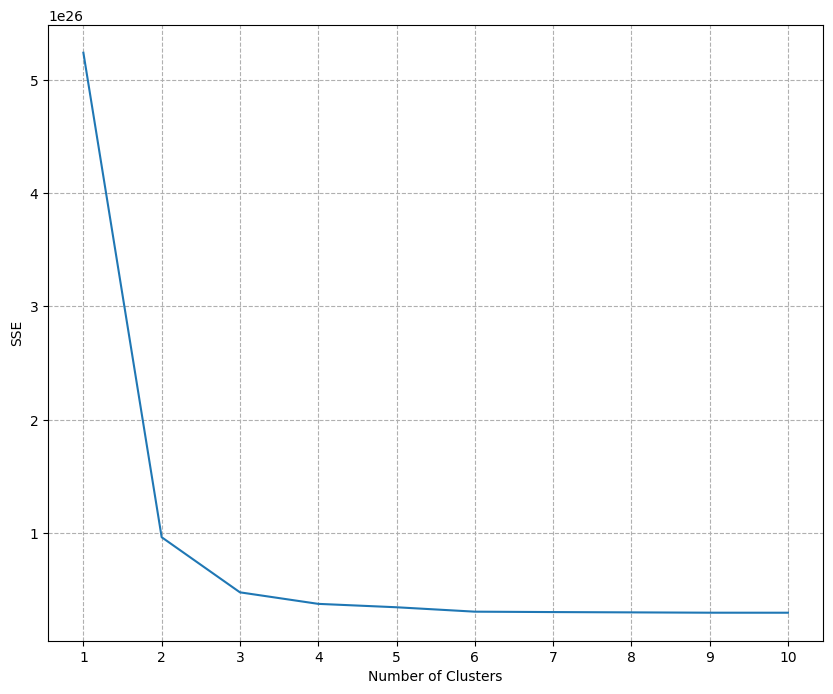

In [35]:
kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 0,
}
sse = []
max_kernels = 10
features = df[factors]
for k in range(1, max_kernels + 1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, max_kernels + 1), sse)
plt.xticks(range(1, max_kernels + 1))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(linestyle='--')

## Elbow Point

In [36]:
kl = KneeLocator(range(1, max_kernels + 1), sse, curve='convex', direction='decreasing')
kl.elbow

2

## Plot clusterizations with different number of clusters and region statistic in them

In [37]:
n_clusters_list = [kl.elbow, 3, 4, 5]
for n in n_clusters_list:
    kmeans = KMeans(
        init='random',
        n_clusters=n,
        n_init=10,
        max_iter=300,
        random_state=0
    )
    kmeans.fit(features)
    name = f'N-Clusters {n}'
    df[name] = kmeans.labels_

    print(name)
    for i in range(n):
        t = df[df[name] == i]
        table = pd.pivot_table(
            t, values=['GDP', 'Population', 'Area'], index=['Region'], aggfunc=np.sum
        )
        table['Density'] = table['Population'] / table['Area']
        table['GDP per capita'] = table['GDP'] / table['Population']
        max_gdp = table['GDP per capita'].max()
        max_density = table['Density'].max()
        max_gdp_region = table[table['GDP per capita'] == max_gdp].index[0]
        max_density_region = table[table['Density'] == max_density].index[0]
        print(f'\tCluster {i}')
        print(f'\t\tMax GDP: {max_gdp}\tRegion: {max_gdp_region}')
        print(f'\t\tMax Density: {max_density}\tRegion: {max_density_region}')

    fig = px.scatter_3d(
        df, x='GDP per capita', y='Area', z='Population',
        color=kmeans.labels_, hover_data=['Country Name', 'Region', 'CO2 emission', 'Density'],
        width=1000, height=800,
        title=f'N-Clusters {n}'
    )
    fig.update(layout_coloraxis_showscale=False)
    fig.show()

N-Clusters 2
	Cluster 0
		Max GDP: 42131.52083010065	Region: North America
		Max Density: 343.9666814206596	Region: South Asia
	Cluster 1
		Max GDP: 57638.15909	Region: North America
		Max Density: 144.1679212532669	Region: East Asia & Pacific


N-Clusters 3
	Cluster 0
		Max GDP: 16366.379137353946	Region: Europe & Central Asia
		Max Density: 1306.62	Region: North America
	Cluster 1
		Max GDP: 42183.2951	Region: North America
		Max Density: 402.8192953460619	Region: South Asia
	Cluster 2
		Max GDP: 57638.15909	Region: North America
		Max Density: 144.1679212532669	Region: East Asia & Pacific


N-Clusters 4
	Cluster 0
		Max GDP: 14626.78085289752	Region: Europe & Central Asia
		Max Density: 1306.62	Region: North America
	Cluster 1
		Max GDP: 42183.2951	Region: North America
		Max Density: 34.50302001624005	Region: East Asia & Pacific
	Cluster 2
		Max GDP: 39965.22390624113	Region: Europe & Central Asia
		Max Density: 402.8192953460619	Region: South Asia
	Cluster 3
		Max GDP: 57638.15909	Region: North America
		Max Density: 144.1679212532669	Region: East Asia & Pacific


N-Clusters 5
	Cluster 0
		Max GDP: 37771.51075860539	Region: Europe & Central Asia
		Max Density: 377.3908172888432	Region: South Asia
	Cluster 1
		Max GDP: 42183.2951	Region: North America
		Max Density: 34.50302001624005	Region: East Asia & Pacific
	Cluster 2
		Max GDP: 39965.22390624113	Region: Europe & Central Asia
		Max Density: 402.8192953460619	Region: South Asia
	Cluster 3
		Max GDP: 57638.15909	Region: North America
		Max Density: 144.1679212532669	Region: East Asia & Pacific
	Cluster 4
		Max GDP: 13374.83316831	Region: North America
		Max Density: 1306.62	Region: North America


## Results

### Проаналізували корельованість параметрів, статистику решіонів в кластерах та намалювали частотні діаграми